In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('titanic3.csv')
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


## <font color='orange'> Data Preparation</font>

In [3]:
# CABIN TYPE
# set the cabin class by stripping the first letter from cabin number
print(f"number of passengers without cabin class: {df['cabin'].isna().sum()}")
# replace NaN with U
df['cabin'] = df['cabin'].replace(np.NaN, 'U')
# get the first letter
df['cabin'] = df['cabin'].astype(str).str[0]
df['cabin'] = df['cabin'].replace('U', 'Unknown')
df['cabin'].value_counts()

number of passengers without cabin class: 1014


Unknown    1014
C            94
B            65
D            46
E            41
A            22
F            21
G             5
T             1
Name: cabin, dtype: int64

In [4]:
# OTHER FEATURES
df['isfemale'] = np.where(df['sex'] == 'female', 1, 0)

# drop some features
cols_to_drop = ['sex', 'name', 'boat', 'body', 'ticket', 'home.dest']
df.drop(cols_to_drop, axis=1, inplace=True)

# make pclass a categorical column
pclass_dic = {1:'First', 2:'Second', 3:'Third'}
df.replace({'pclass': pclass_dic}, inplace=True)

# replace na values
df['embarked'] = df['embarked'].replace(np.NaN, 'Unknown')

df.head()

,pclass,survived,age,sibsp,parch,fare,cabin,embarked,isfemale
0,First,1,29.00,0,0,211.3375,B,S,1
1,First,1,0.92,1,2,151.5500,C,S,0
2,First,0,2.00,1,2,151.5500,C,S,1
3,First,0,30.00,1,2,151.5500,C,S,0
4,First,0,25.00,1,2,151.5500,C,S,1


In [5]:

# create OHE features
df_fin = pd.get_dummies(df, columns=['pclass', 'cabin', 'embarked'], drop_first=True)
df_fin = df_fin.dropna()
df_fin.columns

Index(['survived', 'age', 'sibsp', 'parch', 'fare', 'isfemale',
       'pclass_Second', 'pclass_Third', 'cabin_B', 'cabin_C', 'cabin_D',
       'cabin_E', 'cabin_F', 'cabin_G', 'cabin_T', 'cabin_Unknown',
       'embarked_Q', 'embarked_S', 'embarked_Unknown'],
      dtype='object')

C:\Users\abbas\AppData\Local\Temp\ipykernel_25452\4249911240.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


<AxesSubplot: >

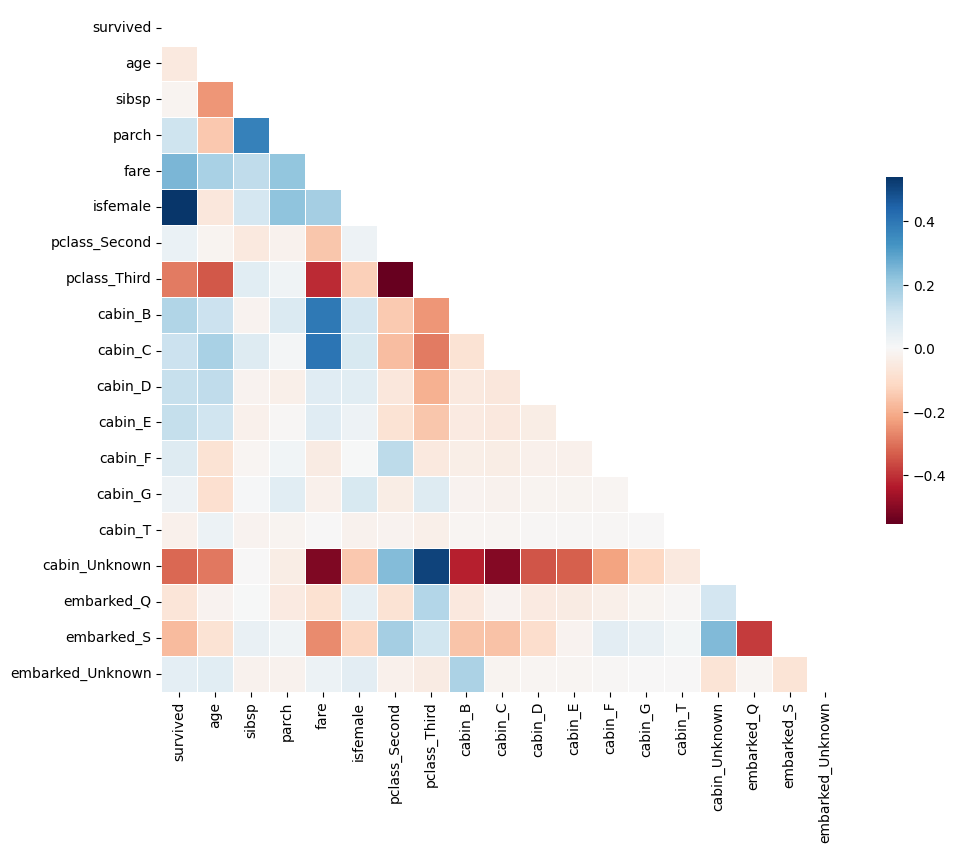

In [10]:
# correlation analysis
corr = df_fin.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = "RdBu"

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

### Train/Test Split

In [20]:
from sklearn.model_selection import train_test_split
X = df_fin.loc[:, df_fin.columns != 'survived']
y = df_fin['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

## <font color='orange'> Catboost</font>

In [21]:
from catboost import CatBoostClassifier
SEED = 42
params = {'loss_function':'Logloss',
           'eval_metric':'AUC',
           'verbose': 10
            }

cbc = CatBoostClassifier(**params)
cbc.fit(X_train, y_train,
    eval_set=(X_test, y_test),
    use_best_model=True,
    plot=True
)

c:\Users\abbas\Desktop\myfiles\Git_Repos\CatB_Xgb\env\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.026988
0:	test: 0.8268991	best: 0.8268991 (0)	total: 142ms	remaining: 2m 21s
10:	test: 0.8396934	best: 0.8552304 (2)	total: 156ms	remaining: 14s
20:	test: 0.8499081	best: 0.8552304 (2)	total: 169ms	remaining: 7.88s
30:	test: 0.8519317	best: 0.8552304 (2)	total: 183ms	remaining: 5.73s
40:	test: 0.8507754	best: 0.8552304 (2)	total: 200ms	remaining: 4.67s
50:	test: 0.8530807	best: 0.8552304 (2)	total: 215ms	remaining: 4s
60:	test: 0.8532216	best: 0.8552304 (2)	total: 229ms	remaining: 3.53s
70:	test: 0.8495597	best: 0.8552304 (2)	total: 244ms	remaining: 3.19s
80:	test: 0.8491149	best: 0.8552304 (2)	total: 261ms	remaining: 2.96s
90:	test: 0.8490408	best: 0.8552304 (2)	total: 279ms	remaining: 2.79s
100:	test: 0.8476620	best: 0.8552304 (2)	total: 296ms	remaining: 2.63s
110:	test: 0.8465131	best: 0.8552304 (2)	total: 313ms	remaining: 2.51s
120:	test: 0.8461276	best: 0.8552304 (2)	total: 331ms	remaining: 2.41s
130:	test: 0.8457718	best: 0.8552304 (2)	total: 353ms	remainin

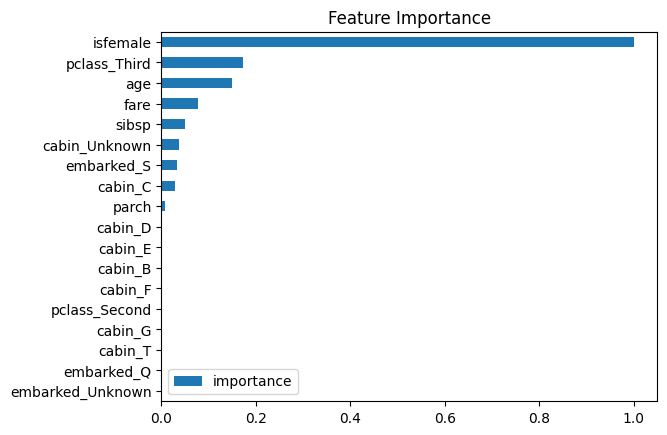

In [22]:
df_vi = pd.DataFrame(data=cbc.feature_importances_, index= cbc.feature_names_, columns=['importance']).sort_values('importance', ascending=True).copy()
df_vi['importance'] = df_vi['importance']/df_vi['importance'].max()
df_vi.plot(kind='barh', title='Feature Importance')
plt.show()

## <font color='green'>SHAP Analysis </font>

In [23]:
import shap
shap.initjs()
# fit the explainer
explainer = shap.Explainer(cbc.predict, X_test)
# calculate the SHAP values
shap_values = explainer(X_test)

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
Permutation explainer: 524it [00:13, 11.37it/s]                         


In [24]:
df.head()

,pclass,survived,age,sibsp,parch,fare,cabin,embarked,isfemale
0,First,1,29.00,0,0,211.3375,B,S,1
1,First,1,0.92,1,2,151.5500,C,S,0
2,First,0,2.00,1,2,151.5500,C,S,1
3,First,0,30.00,1,2,151.5500,C,S,0
4,First,0,25.00,1,2,151.5500,C,S,1


In [25]:
df_fin.head(40)

,survived,age,sibsp,parch,fare,isfemale,pclass_Second,pclass_Third,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_T,cabin_Unknown,embarked_Q,embarked_S,embarked_Unknown
0,1,29.00,0,0,211.3375,1,0,0,1,0,0,0,0,0,0,0,0,1,0
1,1,0.92,1,2,151.5500,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,0,2.00,1,2,151.5500,1,0,0,0,1,0,0,0,0,0,0,0,1,0
3,0,30.00,1,2,151.5500,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,0,25.00,1,2,151.5500,1,0,0,0,1,0,0,0,0,0,0,0,1,0
5,1,48.00,0,0,26.5500,0,0,0,0,0,0,1,0,0,0,0,0,1,0
6,1,63.00,1,0,77.9583,1,0,0,0,0,1,0,0,0,0,0,0,1,0
7,0,39.00,0,0,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,1,53.00,2,0,51.4792,1,0,0,0,1,0,0,0,0,0,0,0,1,0
9,0,71.00,0,0,49.5042,0,0,0,0,0,0,0,0,0,0,1,0,0,0


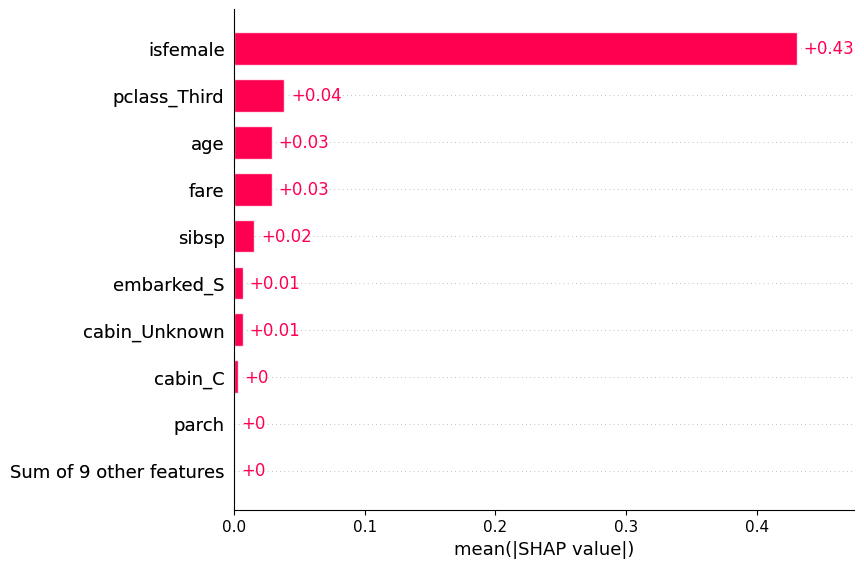

In [26]:
shap.plots.bar(shap_values)

In [27]:
# shap.summary_plot(shap_values)


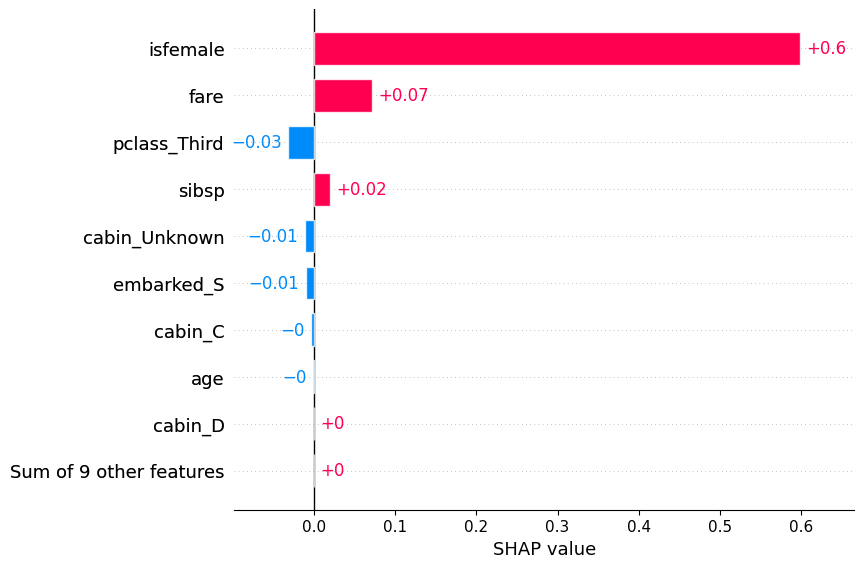

In [28]:
shap.plots.bar(shap_values[0])

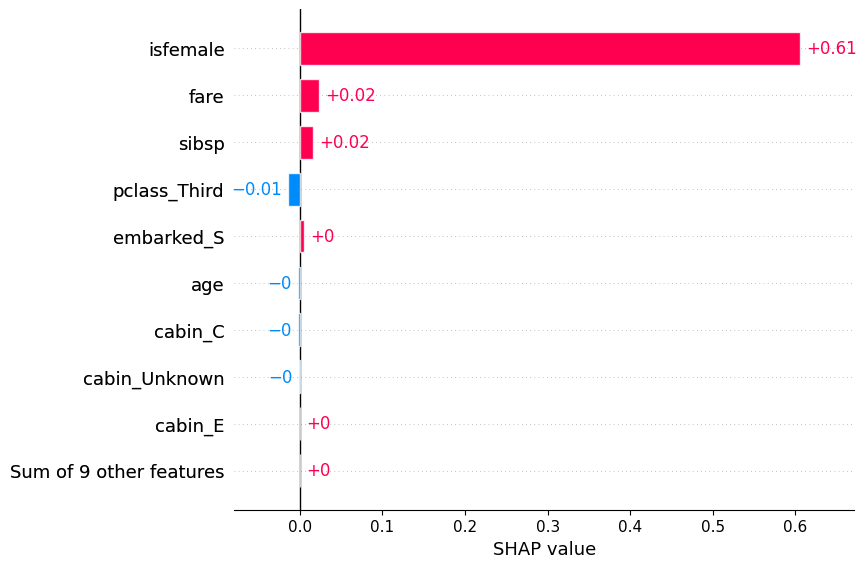

In [29]:
shap.plots.bar(shap_values[100])

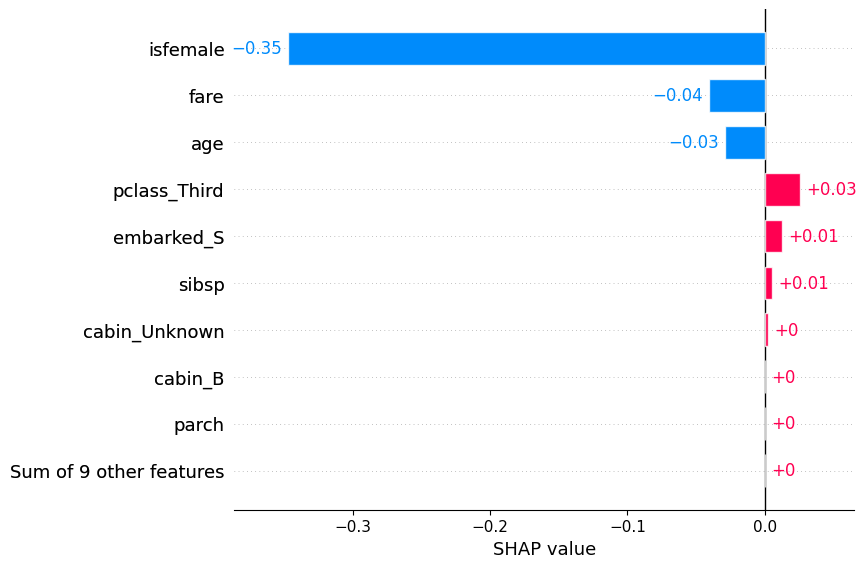

In [30]:
shap.plots.bar(shap_values[105])

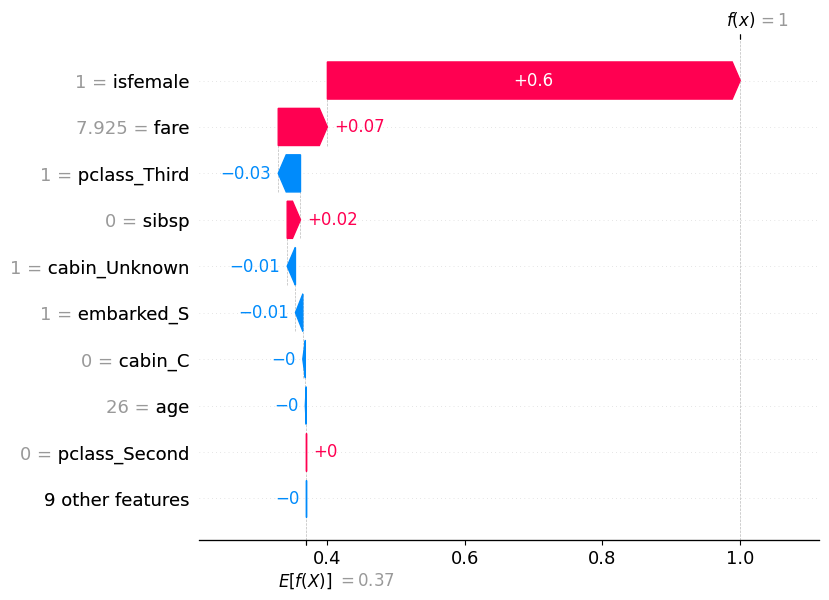

In [31]:
shap.plots.waterfall(shap_values[0])

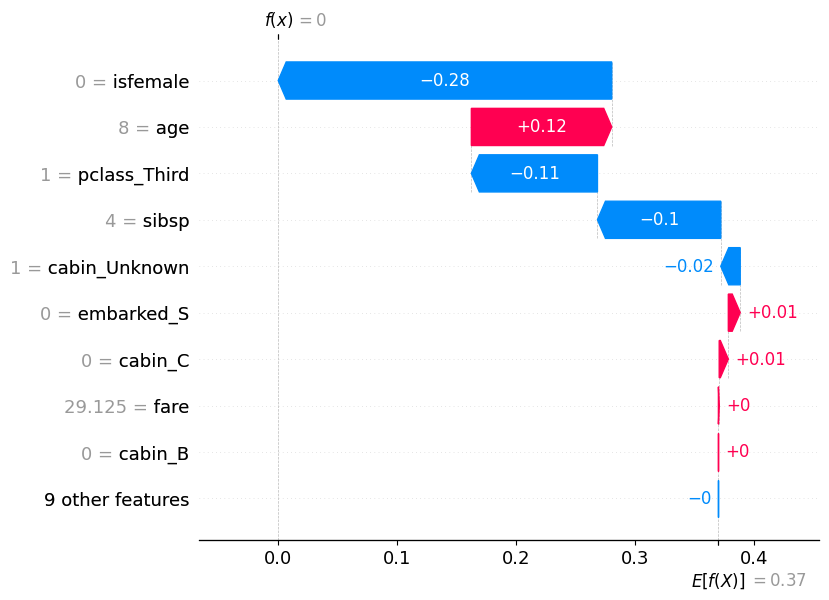

In [32]:
shap.plots.waterfall(shap_values[90])

In [33]:
shap.plots.force(shap_values[0])